### Imports/Data Loading

In [84]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
from scipy                 import stats  as ss
from boruta                import BorutaPy
from matplotlib            import pyplot as plt
from IPython.display       import Image
from IPython.core.display  import HTML
import inflection




In [85]:
df_raw = pd.read_csv("C:\\Users\\igormagro\\Documents\\PropensaoDeCompra\\data\\train.csv")

# 1.0 Descrição dos Dados


In [86]:
df1 = df_raw.copy()


In [87]:
df1.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [88]:
df1.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


## 1.1 Renomeando as colunas

In [89]:
cols_old = df1.columns
snakecase = lambda x: inflection.underscore( x )
cols_new = list( map( snakecase, cols_old ) )

# rename
df1.columns = cols_new

## 1.2 Data Dimensions

In [90]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 381109
Number of Cols: 12


## 1.3 Data Types

In [91]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.4. Check NA

In [92]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.6. Change Data Types

In [93]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.7. Descriptive Statistics

In [94]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64'] )

In [95]:
# Central Tendency - mean, meadina 
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
3,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
6,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


# 2.0. PASSO 02 - FEATURE ENGINEERING

In [121]:
df2 = df1.copy()
df2.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [97]:
print(df2['vehicle_age'].unique())

['> 2 Years' '1-2 Year' '< 1 Year']


In [122]:
df2['vehicle_age'] = df2['vehicle_age'].apply(
    lambda x: 'over2years' if x == '> 2 Years'
    else 'between1and2years' if x == '1-2 Year'
    else 'lessthan1year' if x == '< 1 Year'
    else x
)
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if str(x).strip().lower() == 'yes' else 0)
df2.loc[:,:].groupby('vehicle_damage').size().reset_index(name='counts')

,vehicle_damage,counts
0,0,188696
1,1,192413


# 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS

In [123]:
df3 = df2.copy()

# 4.0. PASSO 04 - ANALISE EXPLORATORIA DOS DADOS

In [124]:
df4 = df3.copy()

## 4.1. Analise Univariada

<Axes: xlabel='age', ylabel='Count'>

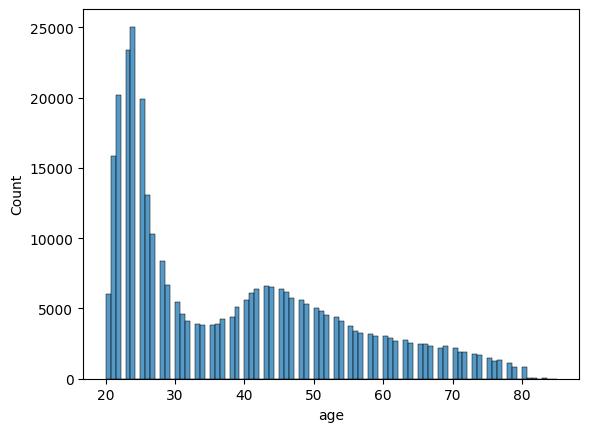

In [101]:
#age
aux = df4.loc[df4['response'] == 0, 'age']
sns.histplot(aux)

<Axes: xlabel='age', ylabel='Count'>

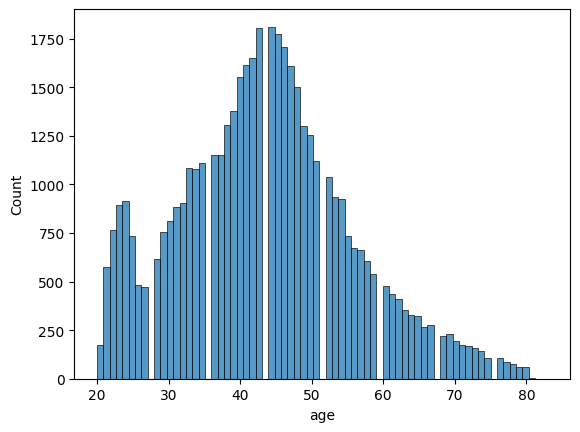

In [102]:
#age
aux = df4.loc[df4['response'] == 1, 'age']
sns.histplot(aux)

<Axes: xlabel='annual_premium', ylabel='Count'>

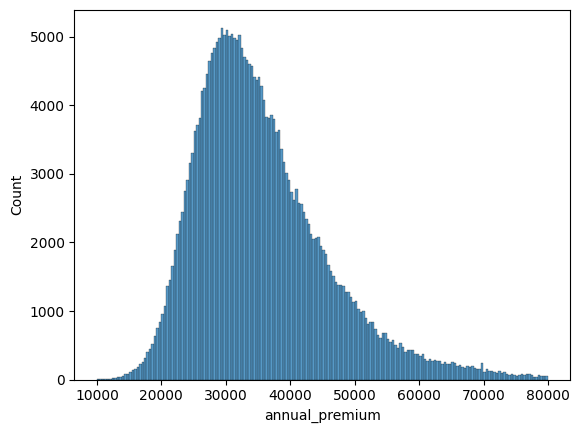

In [103]:
#annual _premium
aux0 = df4[(df4['annual_premium'] < 80000) & (df4['annual_premium'] > 10000)]
aux = aux0.loc[aux0['response'] == 0, 'annual_premium']
sns.histplot(aux)

<Axes: xlabel='annual_premium', ylabel='Count'>

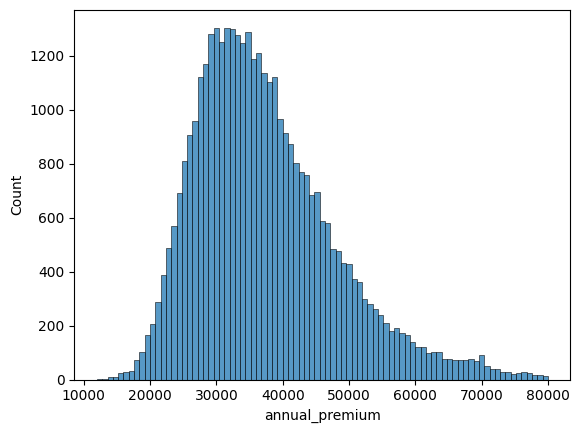

In [104]:
#annual _premium
aux0 = df4[(df4['annual_premium'] < 80000) & (df4['annual_premium'] > 10000)]
aux = aux0.loc[aux0['response'] == 1, 'annual_premium']
sns.histplot(aux)

<Axes: xlabel='response', ylabel='driving_license'>

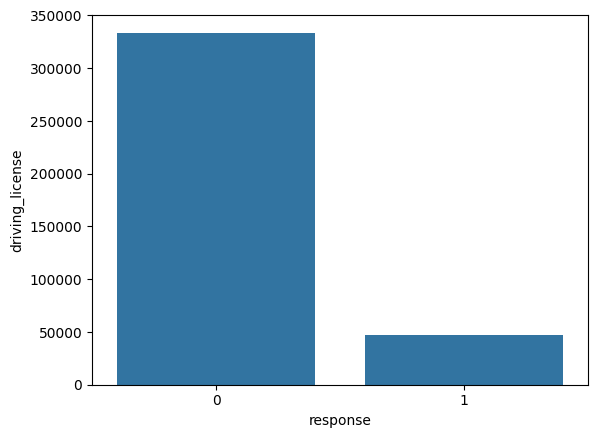

In [105]:
# driving_license
aux = df4[['driving_license', 'response']].groupby('response').sum().reset_index()
sns.barplot(x='response', y='driving_license', data=aux)

<Axes: xlabel='region_code', ylabel='id'>

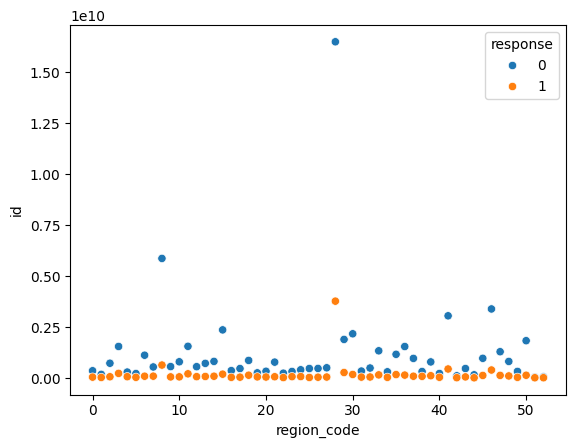

In [106]:
# region_code
aux3 = df4[['id','region_code', 'response']].groupby(['region_code', 'response']).sum().reset_index()
sns.scatterplot(x='region_code', y='id', hue='response', data=aux3)

In [117]:
# previously_insured
pd.crosstab(df4['previously_insured'], df4['response'])

response,0,1
previously_insured,,
0,159929,46552
1,174470,158


In [108]:
# vehicle_age
df4[['vehicle_age', 'response']].value_counts(normalize=True).reset_index()



,vehicle_age,response,proportion
0,between1and2years,0,0.434285
1,lessthan1year,0,0.413488
2,between1and2years,1,0.091328
3,over2years,0,0.029663
4,lessthan1year,1,0.018897
5,over2years,1,0.012338


In [125]:
#vehicle_damage
pd.crosstab(df4['vehicle_damage'], df4['response'])

response,0,1
vehicle_damage,,
0,187714,982
1,146685,45728


<Axes: xlabel='response', ylabel='policy_sales_channel'>

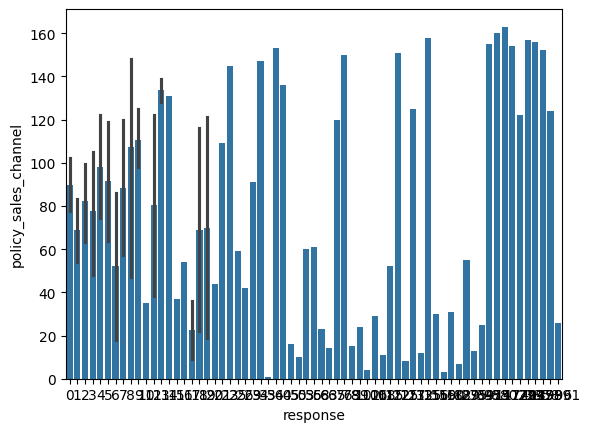

In [126]:
#policy_sales_channel
aux = df3[['policy_sales_channel', 'response']].groupby('policy_sales_channel').sum().reset_index()
sns.barplot(x='response', y='policy_sales_channel', data = aux)

## 4.2. Analise Bivariada

## 4.3. Analise Multivariada

# 5.0. PASSO 05 - DATA PREPARATION

In [128]:
df5 = df4.copy()
df5.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

## 5.1. Normalizacao

## 5.2. Rescaling

## 5.3. Transformacao

### 5.3.1. Encoding